In [1]:
from Dataload import dataload

from module import resnet,transformer,video_model,invres

import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from torchvision import  utils
#Batchfy


#Counts number of correct label
def num_correct(prediction,labels):
    correct=0
    for i,(pred_label,label) in enumerate(zip(prediction,labels)):
        if (pred_label.item()==label.item()):
            correct +=1
    return correct


train_data=dataload.Video_Frame_Data('Dataset/Train_labels.txt',base_path_v='Dataset/Train',strict_num=26)
valid_data=dataload.Video_Frame_Data('Dataset/Val_labels.txt',base_path_v='Dataset/Val',strict_num=26)

model=video_model.Video_Feature(joint=False,grayscale=False,classfication=True)

for name, child in model.named_children():
   if not name in ['densenet']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False
            
            
train_dataloader = DataLoader(train_data, batch_size=32
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(valid_data, batch_size=32
                       , num_workers=0)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:03<00:00, 8.78MB/s]


densenet is frozen
fc2 is unfrozen
fc3 is unfrozen
posencoding is unfrozen
transformer is unfrozen


In [3]:
len(train_dataloader)

84

In [4]:
len(valid_dataloader)

24

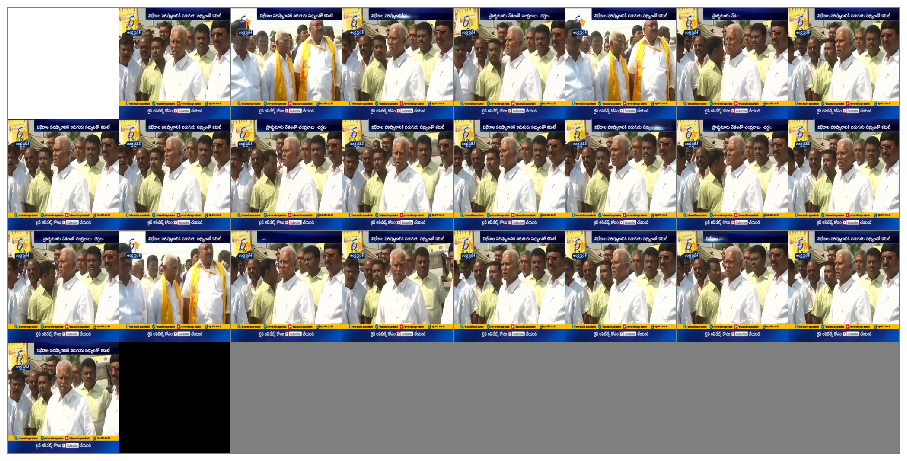

In [9]:
input=train_data[0][0]
plt.figure(figsize=(16, 16))
grid_border_size = 2
grid = utils.make_grid(input)

plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
plt.axis('off')
plt.ioff()
plt.show()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [11]:
model=model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()  
loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0002, betas=(0.5, 0.999))


In [13]:
#Triaining
train_loss=[]
valid_accuracy=[]
num_epochs=75

model.train()
for epochs in range(0,num_epochs):
    first=True
    model.train()
    correct=0
    total_samples=0
    
    print("Training Epoch: ", epochs+1,"\n")
    for i_batch, (sample_batched,_,label) in enumerate(train_dataloader):
        
        batch_size=sample_batched.size(0)
        optimizer.zero_grad()
        sample_batched=sample_batched.to(device)
        output=model(sample_batched)
        loss=criterion(output,label.to(device))
        #loss=loss_func(output,label.float().to(device))
        loss.backward()
        predicted = torch.max(output, 1)
        prediction=predicted.indices.detach().cpu()
        correct +=num_correct(prediction,label)
        total_samples+=batch_size
        accuracy=correct/(total_samples)
        optimizer.step()
        true_label=label.detach().cpu()
        if first:
            first=False
            conf_mat=confusion_matrix( true_label,prediction,labels=[0,1,2])
        else:
            conf_mat+=confusion_matrix(true_label,prediction,labels=[0,1,2])
        if i_batch%20==0:
            print(label)
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("Recognition loss: ", loss.item())
            train_loss.append(loss.item())
            
            print("Avearage Accuracy: ", accuracy)
    print(conf_mat)
    torch.save(model,"model.h")
    print("Validation\n")
    
    model.eval()   
    correct=0
    total_samples=0
    avg_loss=0
    first=True
    for i_batch, (sample_batched,_,label) in enumerate(valid_dataloader):
        batch_size=sample_batched.size(0)
        sample_batched=sample_batched.to(device)
        output=model(sample_batched)
        loss=criterion(output,label.to(device))
      #  loss=loss_func(output,label.float().to(device))
        avg_loss+=loss.item()
        predicted = torch.max(output, 1)
        prediction=predicted.indices.detach().cpu()
        correct +=num_correct(prediction,label)
        total_samples+=batch_size
        accuracy=correct/(total_samples)
        true_label=label.detach().cpu()
        if first:
            first=False
            conf_mat=confusion_matrix( true_label,prediction,labels=[0,1,2])
        else:
            conf_mat+=confusion_matrix(true_label,prediction,labels=[0,1,2])
    print(conf_mat)
    print(avg_loss/len(valid_dataloader))
    valid_accuracy.append(accuracy)
    print("Accuracy: ", accuracy)


Training Epoch:  1 

tensor([2, 1, 0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 2,
        0, 1, 1, 2, 1, 0, 0, 0], device='cpu')
Batch:  1 / 84
Recognition loss:  1.0851496458053589
Avearage Accuracy:  0.34375
tensor([2, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 2, 1, 1, 1,
        0, 1, 2, 1, 0, 1, 1, 0], device='cpu')
Batch:  21 / 84
Recognition loss:  0.9416518211364746
Avearage Accuracy:  0.4836309523809524
tensor([2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1,
        2, 0, 1, 1, 1, 1, 1, 0], device='cpu')
Batch:  41 / 84
Recognition loss:  0.9301438927650452
Avearage Accuracy:  0.5
tensor([2, 0, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2,
        1, 2, 2, 0, 0, 0, 1, 1], device='cpu')
Batch:  61 / 84
Recognition loss:  1.0515010356903076
Avearage Accuracy:  0.5153688524590164
tensor([1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2,
        2, 0, 1, 0, 0, 2, 0, 1], device='cpu')

/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Video_Feature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + 

Validation

[[ 25  67 207]
 [  3 137 141]
 [  2  11 173]]
1.0818819378813107
Accuracy:  0.43733681462140994
Training Epoch:  2 

tensor([2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2,
        0, 1, 2, 2, 0, 2, 2, 2], device='cpu')
Batch:  1 / 84
Recognition loss:  1.0604695081710815
Avearage Accuracy:  0.46875
tensor([2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0,
        0, 0, 1, 0, 1, 0, 2, 2], device='cpu')
Batch:  21 / 84
Recognition loss:  0.9240089654922485
Avearage Accuracy:  0.6041666666666666
tensor([1, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2,
        1, 0, 1, 1, 2, 0, 1, 1], device='cpu')
Batch:  41 / 84
Recognition loss:  0.9991289377212524
Avearage Accuracy:  0.5922256097560976
tensor([0, 1, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2,
        2, 1, 0, 2, 0, 2, 2, 0], device='cpu')
Batch:  61 / 84
Recognition loss:  0.9961981773376465
Avearage Accuracy:  0.5988729508196722
ten

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-b0cacb05bf9e>", line 14, in <module>
    for i_batch, (sample_batched,_,label) in enumerate(train_dataloader):
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 346, in __next__
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/notebooks/Github/EmotiW2020/Dataload/dataload.py", line 81, in __getitem__
    tempimg=self.transform(

KeyboardInterrupt: 

In [ ]:
avg_loss/len(valid_dataloader)

In [ ]:
torch.save(model,"First")

In [ ]:
first=True
correct=0
total_samples=0
for i_batch, (sample_batched,_,label) in enumerate(valid_dataloader):
    print("Current Batch: ",i_batch)
    batch_size=sample_batched.size(0)

    label=label.to(device)
    sample_batched=sample_batched.to(device)
    output=model(sample_batched)
    predicted = torch.max(output, 1)
    prediction=predicted.indices.detach().cpu()
    correct +=num_correct(prediction,label)
    total_samples+=batch_size
    accuracy=correct/(total_samples)
    true_label=label.detach().cpu()
    if first:
        first=False
        conf_mat=confusion_matrix( true_label,prediction,labels=[0,1,2])
    else:
        conf_mat+=confusion_matrix(true_label,prediction,labels=[0,1,2])

print(conf_mat)
print("Accuracy: ", accuracy)

In [ ]:
len(valid_dataloader)

In [ ]:
train_accuracy=[]

In [ ]:
train_accuracy.append(3)

In [ ]:
train_accuracy

In [ ]:
train_loss